In [1]:
import gspread
import pandas as pd
import re
from gspread_dataframe import get_as_dataframe
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import numpy as np
import textwrap

In [2]:
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.size": 15,  # 默认字体大小
        "axes.titlesize": 17,  # 标题字体
        "axes.labelsize": 15,  # 坐标轴标签
        "xtick.labelsize": 13,  # x 轴刻度
        "ytick.labelsize": 13,  # y 轴刻度
        "legend.fontsize": 13,  # 图例字体
    }
)

In [3]:
CREDENTIALS_JSON = "../rm4mt-463314-3ce1280ee29c.json"
sheet_urls = [
    "https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1LHsMMvKhTEgagmZKQl7ax1H4BJyDBImYMbeE8sNPjJw/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1PRIfwNA4l2TG3oMFlgM8LIGuxvCH8prfgEvbGMDhqIY/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/11WAU3v3uKN1wV3G7crmGDyo3u4QX4aGlhWpQN7tn9As/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1pSBxhdqGvu2I5z_8C6l6pePV-IkIl31MM83Py_ILRqU/edit?usp=sharing",
]

In [4]:
gc = gspread.service_account(filename=CREDENTIALS_JSON)
all_data = {}

In [5]:
for sheet_url in sheet_urls:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how="all").dropna(axis=1, how="all")
        ws_data[worksheet.title] = df
        time.sleep(2)
    all_data[sheet_url] = ws_data

Reading Sheet: https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing


In [6]:
def split_by_metric(all_data):
    dfs_by_metric = defaultdict(list)  # metric: list of rows

    for sheet_url, ws_dict in all_data.items():
        for ws_name, df in ws_dict.items():
            match = re.match(
                r"(.+?)_((comet_score|comet_kiwi_score|grb|grf|gea_100|gea_5|thinking_length))$",
                ws_name,
            )
            if not match:
                continue
            task = match.group(1)
            metric = match.group(2)
            # Check must have model & lang_pair
            if not {"model", "lang_pair"}.issubset(df.columns):
                continue
            # Budget Column - include numeric columns and "low", "high"
            numeric_cols = [
                col
                for col in df.columns
                if isinstance(col, (int, float))
                or (isinstance(col, str) and col.isdigit())
            ]
            text_budget_cols = [col for col in df.columns if col in ["low", "high"]]
            budget_cols = sorted(numeric_cols, key=lambda x: int(x)) + text_budget_cols

            for _, row in df.iterrows():
                model = row["model"]
                lang_pair = row["lang_pair"]
                for budget in budget_cols:
                    val = row[budget]
                    if pd.isna(val):
                        continue
                    # Handle budget value - keep as string for "low"/"high", convert to int for numeric
                    budget_val = budget if budget in ["low", "high"] else int(budget)
                    dfs_by_metric[metric].append(
                        {
                            "model": model,
                            "task": task,
                            "metric": metric,
                            "lang_pair": lang_pair,
                            "budget": budget_val,
                            "score": float(val),
                        }
                    )

    # To DataFrame
    for metric in dfs_by_metric:
        dfs_by_metric[metric] = pd.DataFrame(dfs_by_metric[metric])

    return dfs_by_metric


dfs_by_metric = split_by_metric(all_data)

In [7]:
grb_df = dfs_by_metric["grb"]
grok_grb_df = grb_df[
    (grb_df["lang_pair"] == "Avg") & (grb_df["model"] == "grok-3-mini")
]

# grok_grb_df

In [8]:
wide = grok_grb_df.pivot_table(
    index=["task", "metric", "lang_pair"], columns="budget", values="score"
).reset_index()
wide.columns.name = None
wide["delta"] = wide["high"] - wide["low"]

In [9]:
wide.loc[wide["task"] == "DRT-Gutenberg", "task"] = "MetaphorTrans"
wide.loc[wide["task"] == "LITEVAL-CORPUS", "task"] = "LitEval-Corpus"
wide.loc[wide["task"] == "WMT-Literary", "task"] = "WMT24-Literary"
wide.loc[wide["task"] == "WMT23-Biomedical-Doc", "task"] = "WMT23-Biomedical"
wide = wide[wide["task"] != "WMT23-Biomedical-Sentence"].reset_index(drop=True)

In [10]:
wide

,task,metric,lang_pair,high,low,delta
0,CAMT,grb,Avg,88.996028,88.977142,0.018886
1,CommonsenseMT-Contextless,grb,Avg,89.977778,90.757778,-0.780000
2,CommonsenseMT-Contextual,grb,Avg,93.611429,93.551429,0.060000
3,CommonsenseMT-Lexical,grb,Avg,93.412500,92.962500,0.450000
4,MetaphorTrans,grb,Avg,93.679500,93.717500,-0.038000
5,LitEval-Corpus,grb,Avg,94.604599,94.583235,0.021364
6,RAGtrans,grb,Avg,95.096000,95.068000,0.028000
7,RTT,grb,Avg,95.005000,95.038000,-0.033000
8,WMT24-Literary,grb,Avg,92.353535,92.958297,-0.604762
9,WMT23-Biomedical,grb,Avg,93.636939,93.605947,0.030991


In [11]:
# # === 1) 斜率图 (Slopegraph) ===
# plt.figure(figsize=(9, 5))
# x = [0, 1]
# for _, row in wide.iterrows():
#     y = [row["low"], row["high"]]
#     plt.plot(x, y, marker="o", linewidth=1)
# # 轴与标注
# plt.xticks(x, ["Low effort", "High effort"])
# plt.ylabel("Score")
# plt.title("Grok-3-mini: Paired Scores per Task (Low vs High)")
# for _, row in wide.iterrows():
#     plt.text(1.02, row["high"], row["task"], va="center", fontsize=8)
# plt.tight_layout()
# plt.show()

In [12]:
# # === 2) Δ-条形图 (Delta Bar) ===
# wide_sorted = wide.sort_values("delta")
# plt.figure(figsize=(9, 6))
# ypos = np.arange(len(wide_sorted))
# plt.barh(ypos, wide_sorted["delta"])
# plt.yticks(ypos, wide_sorted["task"])
# plt.axvline(0, linestyle="--", color="black")
# plt.xlabel("Δ = High - Low")
# plt.title("Delta by Task (sorted)")
# mean_delta = wide["delta"].mean()
# plt.axvline(mean_delta, linestyle=":", color="red", label=f"mean Δ = {mean_delta:.3f}")
# plt.legend()
# plt.tight_layout()
# plt.show()

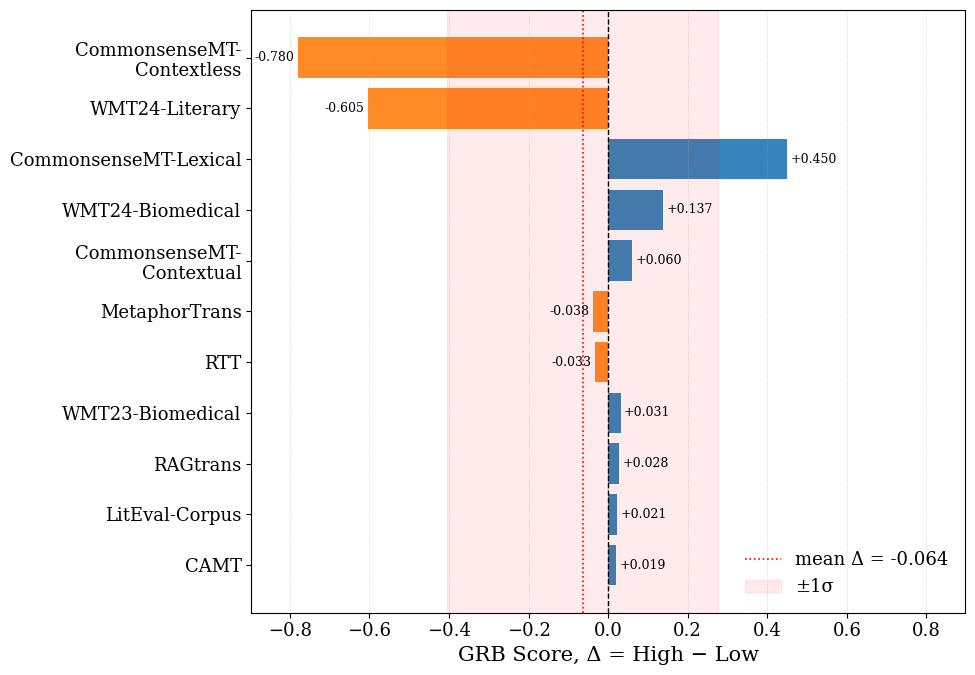

In [17]:
# 1)（可选）按“绝对差值”排序，更突出两端
wide_sorted = wide.copy()
wide_sorted["abs_delta"] = wide_sorted["delta"].abs()
wide_sorted = wide_sorted.sort_values(
    "abs_delta", ascending=True
)  # 小→大；想大→小就 False

# 2) 颜色：Δ≥0 一色，Δ<0 另一色
colors = np.where(wide_sorted["delta"] >= 0, "tab:blue", "tab:orange")

# 3) 画图
plt.figure(figsize=(10, 7))
ypos = np.arange(len(wide_sorted))
plt.barh(ypos, wide_sorted["delta"], color=colors, alpha=0.9)

# 4) 对称坐标轴（围绕 0）
xmax = wide_sorted["abs_delta"].max()
pad = 0.15 * xmax if xmax > 0 else 0.5
plt.xlim(-xmax - pad, xmax + pad)

# 5) 网格 & 参照线
plt.axvline(0, linestyle="--", color="black", linewidth=1)
mean_delta = wide["delta"].mean()
std_delta = wide["delta"].std(ddof=1)
plt.axvline(
    mean_delta,
    linestyle=":",
    color="red",
    linewidth=1.2,
    label=f"mean Δ = {mean_delta:.3f}",
)
plt.axvspan(
    mean_delta - std_delta, mean_delta + std_delta, alpha=0.08, color="red", label="±1σ"
)

plt.grid(axis="x", linestyle=":", linewidth=0.6, alpha=0.6)


# 6) y 轴标签（长任务名自动换行，防止挤）
def wrap_name(s, width=22):
    return "\n".join(textwrap.wrap(str(s), width=width))


yticklabels = [wrap_name(t) for t in wide_sorted["task"]]
plt.yticks(ypos, yticklabels)

# 7) 数值标注（条末尾标 Δ）
for y, v in zip(ypos, wide_sorted["delta"]):
    align = "left" if v >= 0 else "right"
    offset = 0.01 * (xmax + pad)  # 小偏移
    xtext = v + offset if v >= 0 else v - offset
    plt.text(xtext, y, f"{v:+.3f}", va="center", ha=align, fontsize=9)

plt.xlabel("GRB Score, Δ = High − Low")
# plt.title("Grok-3-mini · Delta by Task (sorted by |Δ|, symmetric axis)")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
plt.savefig("grok_grb_delta_bar.png", dpi=900, format="png", bbox_inches="tight")
plt.savefig("grok_grb_delta_bar.pdf", dpi=1200, format="pdf", bbox_inches="tight")
plt.show()

In [14]:
# wide_sorted

In [15]:
# # === 3) 散点图 (Low vs High) ===
# plt.figure(figsize=(6, 6))
# plt.scatter(wide["low"], wide["high"])
# mn = min(wide["low"].min(), wide["high"].min())
# mx = max(wide["low"].max(), wide["high"].max())
# plt.plot([mn, mx], [mn, mx], linestyle="--", color="gray")
# plt.xlabel("Low effort")
# plt.ylabel("High effort")
# plt.title("Low vs High (identity line)")
# for _, row in wide.iterrows():
#     plt.annotate(
#         row["task"],
#         (row["low"], row["high"]),
#         xytext=(3, 3),
#         textcoords="offset points",
#         fontsize=8,
#     )
# plt.tight_layout()
# plt.show()